In [1]:
import matplotlib
%matplotlib notebook
#
from collections import OrderedDict
from best.hVI_fsrm import SPaths
from best.hVI_fsrm import spec_Spaths
from best.hVI_models import State_Space, Det_SI_Model
from best.hVI_types import Env, Gamma
import best.rss18_functions as rf
from best.hVI_config import sc, load, parr, obs_action, epsilon, rand_seed
import numpy as np
from collections import OrderedDict


import matplotlib.pyplot as plt
import random
import time
from best.fsa import Fsa
from best.hVI_fsrm import plot_optimizer
from best.hVI_fsrm import simulate
import networkx
%matplotlib --list
# %config InlineBackend.figure_format = 'retina'

Available matplotlib backends: ['osx', 'qt4', 'qt5', 'gtk3', 'notebook', 'wx', 'qt', 'nbagg', 'agg', 'gtk', 'tk', 'ipympl', 'inline']


In [2]:
print("Setting up Scenario")

# Define Regions
# Regs have the same format as RSS code. Regs that are added first have a higher priority
#### Wall region
print("Started wall case")
regs = OrderedDict()


a1 = rf.vertex_to_poly(np.array([[4, 0], [5, 0], [5, 1], [4, 1]]))
regs['a1'] = (a1, 0.9, 'sample1', 0)

a2 = rf.vertex_to_poly(np.array([[4, -3], [5, -3], [5, -2], [4, -2]]))
regs['a2'] = (a2, 0.3, 'sample2', 1)

output_color = {'a1': 'green','a2': 'blue', 'null': 'white'}

# Define Null regions with bounds of the space for null output with lowest priority
p = rf.vertex_to_poly(np.array([[-3, -5], [-3, 5], [5, -5], [5, 5]]))
regs['null'] = (p, 1.0, 'null')

# Construct belief-MDP for env
env = Env(regs)


Setting up Scenario
Started wall case


In [3]:
''' Configuration Parameters '''
random.seed(rand_seed)
np.random.seed(rand_seed)

print('''--- Setup Motion and Observation Models ---''')
# Define Motion and Observation Model
Wx = np.eye(2)
Wu = np.eye(2)
r2_bs = State_Space([-5, -5], [5, 5])
motion_model = Det_SI_Model(0.1)

--- Setup Motion and Observation Models ---
 The used model contains an integrator for each dimension:

[[1. 0.]
 [0. 1.]]


# Construct a roadmap for two sample regions

---- Constructing ROADMAP ----


<IPython.core.display.Javascript object>


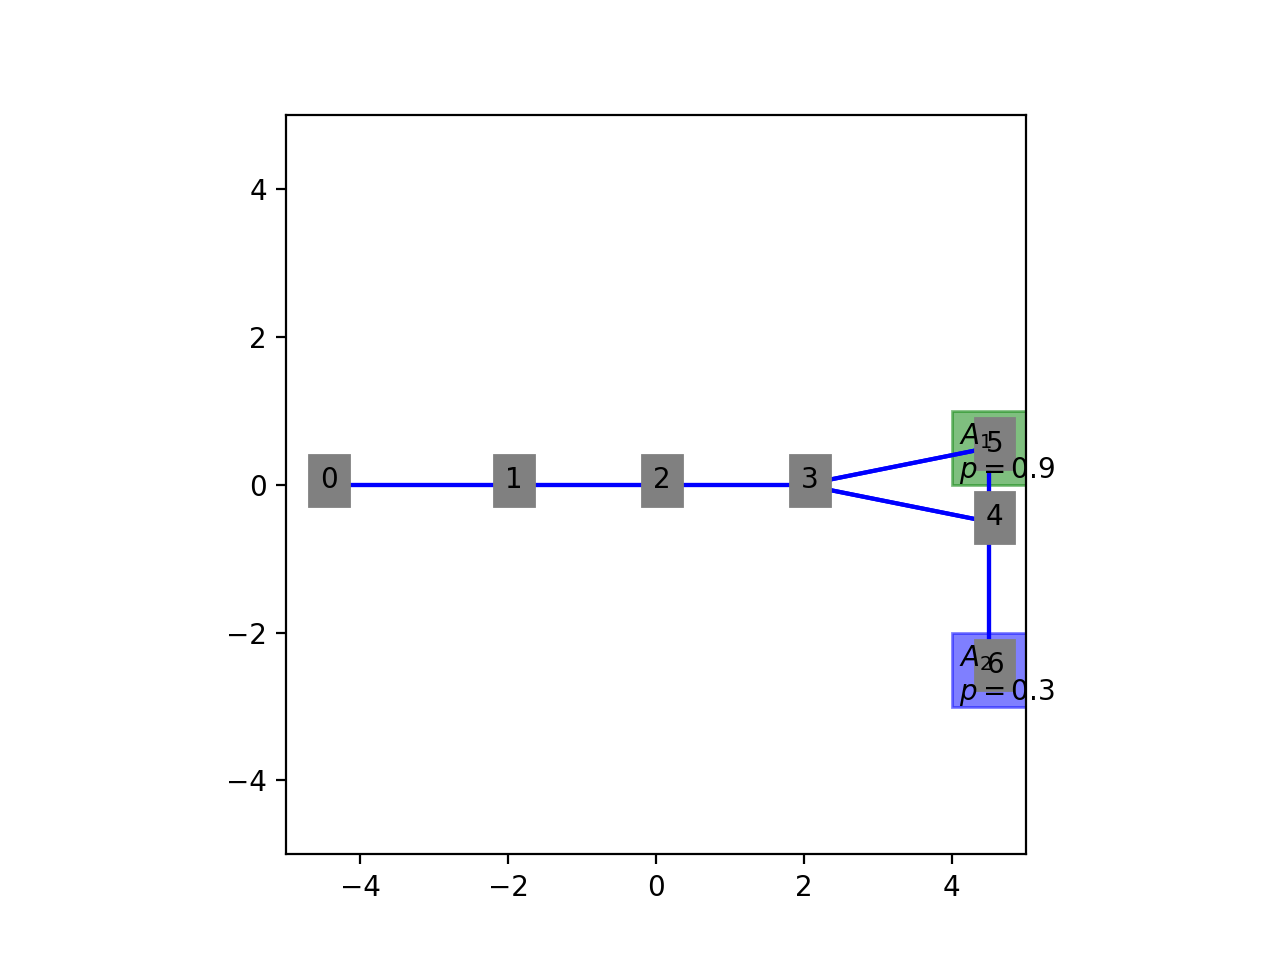

[[1. 0.]
 [0. 1.]]
[[0.1 0. ]
 [0.  0.1]]
[[10.51249  0.     ]
 [ 0.      10.51249]]


In [4]:
print("---- Constructing ROADMAP ----")
fig = plt.figure(1)
ax = fig.add_subplot(111, aspect='equal')
prm = SPaths(r2_bs, motion_model, Wx, Wu, regs, output_color, ax)
prm.make_nodes_edges(7, 3, means=[np.array([[-4.5],[0]]),np.array([[-2],[0]]),np.array([[0],[0]]),
                                   np.array([[2],[0]]),np.array([[4.5],[-.5]]),
                                   np.array([[4.5],[0.5]]),np.array([[4.5],[-2.5]])])
                                   
prm.plot(ax)
plt.show();

In [5]:
print('-- Generate the DFA and the Product model----')

props = ['obs', 'sample1', 'sample2']
props = dict(zip(props, map(lambda x: 2 ** x, range(0, len(props)))))
print(props)
fsa = Fsa()
vars(Fsa)
fsa.g.add_node(0)
fsa.g.add_node('trap')
fsa.g.add_node(1)

fsa.g.add_edge(0,1, weight=0, input={props['sample1'],props['sample2'],props['sample2']+props['sample1']})
fsa.g.add_edge(0,0, weight=0, input={0})
fsa.g.add_edge(0,'trap', weight=0, input={props['obs']})

 

fsa.props=props
fsa.final = {1}
fsa.init = dict({0:1})

-- Generate the DFA and the Product model----
{'sample1': 2, 'obs': 1, 'sample2': 4}


In [6]:
fsaform = Fsa()
form = '! obs U sample'
fsaform.from_formula(form)
vars(fsa.g)
print(fsaform.g.edges(data=True))
formula_fsa = dict()
formula_fsa['fsa'] = fsa
formula_fsa['init'] = dict({0:1})
formula_fsa['final'] = {1}
formula_fsa['prop'] = props

prod_ = spec_Spaths(prm, formula_fsa,env,n=10)


[(u'1', u'1', {'input': set([0, 1, 2, 3]), 'guard': '(1)', 'weight': 0, 'label': '(1)'}), (u'0', u'1', {'input': set([1, 3]), 'guard': u'sample', 'weight': 0, 'label': u'sample'}), (u'0', u'0', {'input': set([0]), 'guard': u'(!sample & !obs)', 'weight': 0, 'label': u'(!sample & !obs)'})]


# Specify formula
Get sample in A1 or in A2

<IPython.core.display.Javascript object>


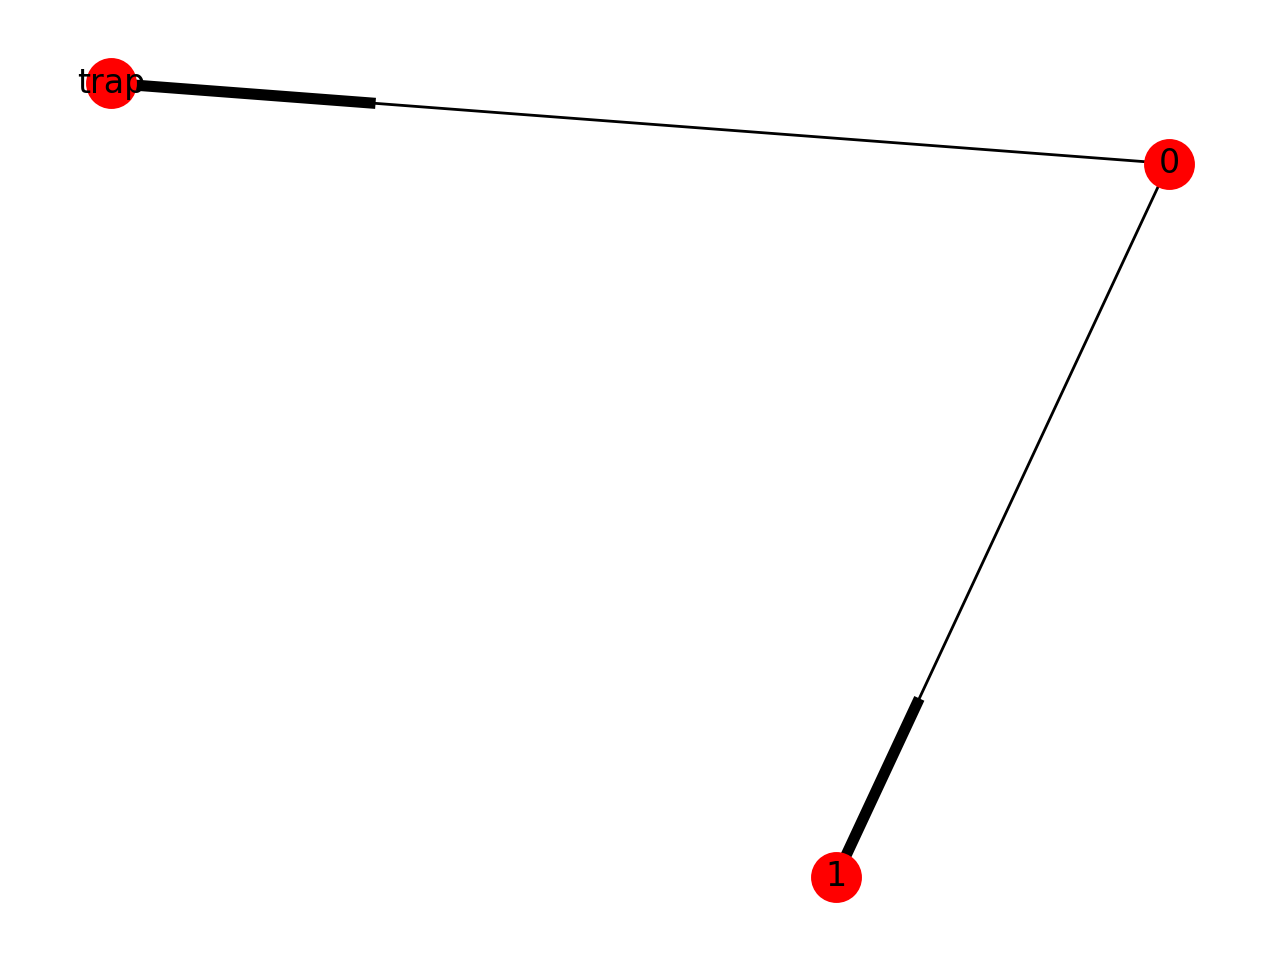

In [7]:
fig = plt.figure()


networkx.draw(fsa.g,pos=networkx.spring_layout(fsa.g),with_labels=True)
plt.draw()
plt.show()

# Start Back-ups 

In [8]:
print('--- Start Back-ups ---')

not_converged = True
i = 0
n = prod_.init[0]

opts = dict()
for i in range(20):
    print('iteration', i)
    not_converged = prod_.full_back_up(opts)
    opt = np.unique(prod_.val[n].best_edge)



--- Start Back-ups ---
('iteration', 0)
('iteration', 1)
('iteration', 2)
('iteration', 3)
('iteration', 4)
('iteration', 5)
('iteration', 6)
('iteration', 7)
('iteration', 8)
('iteration', 9)
('iteration', 10)
('iteration', 11)
('iteration', 12)
('iteration', 13)
('iteration', 14)
('iteration', 15)
('iteration', 16)
('iteration', 17)
('iteration', 18)
('iteration', 19)


# Prune

<IPython.core.display.Javascript object>


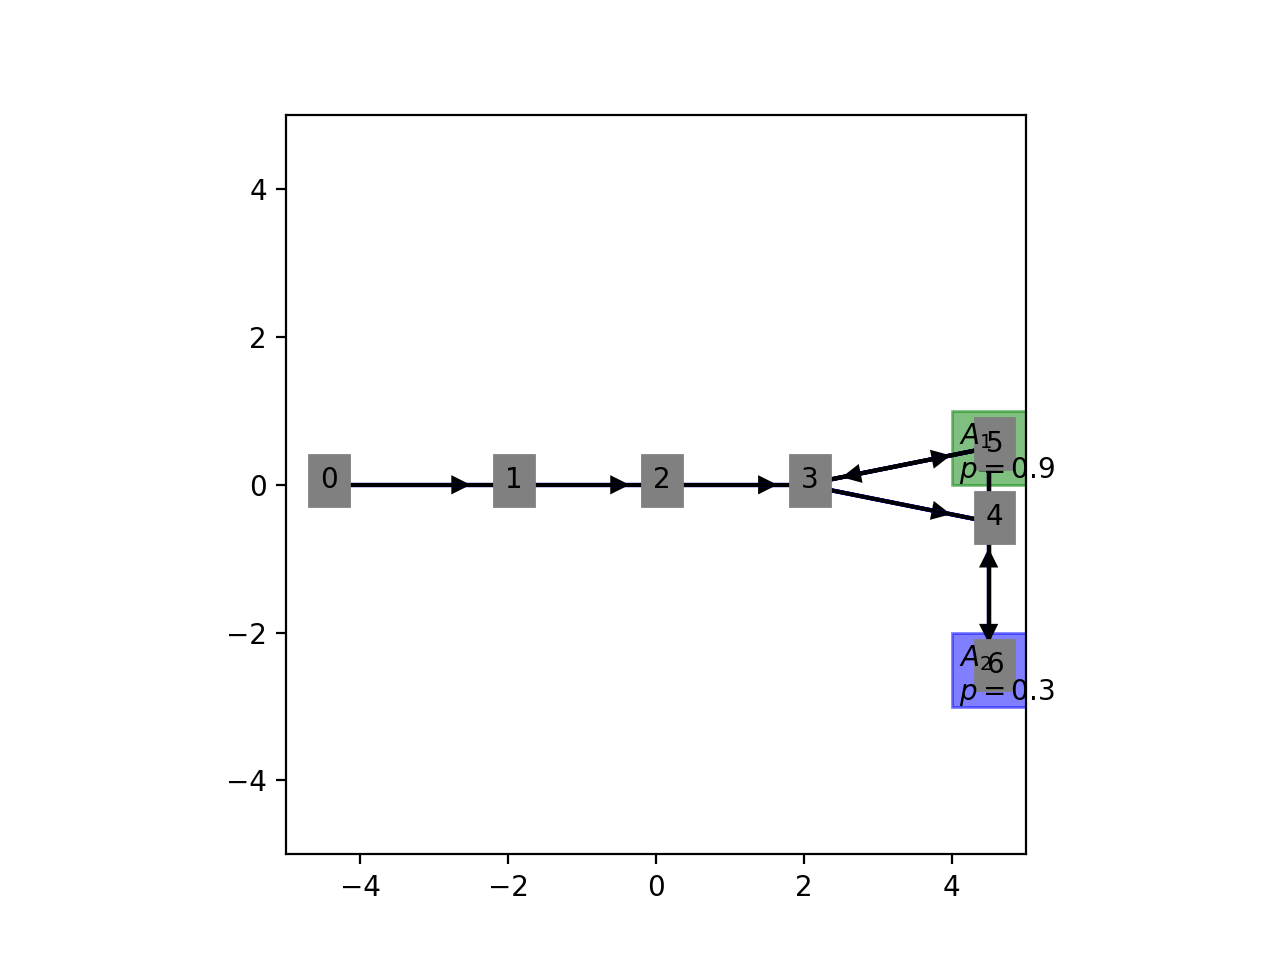

start
10


In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
prm.plot(ax)
nodes, edges, visited = plot_optimizer(prod_, ax)
prod_.prune(keep_list=visited)

<IPython.core.display.Javascript object>


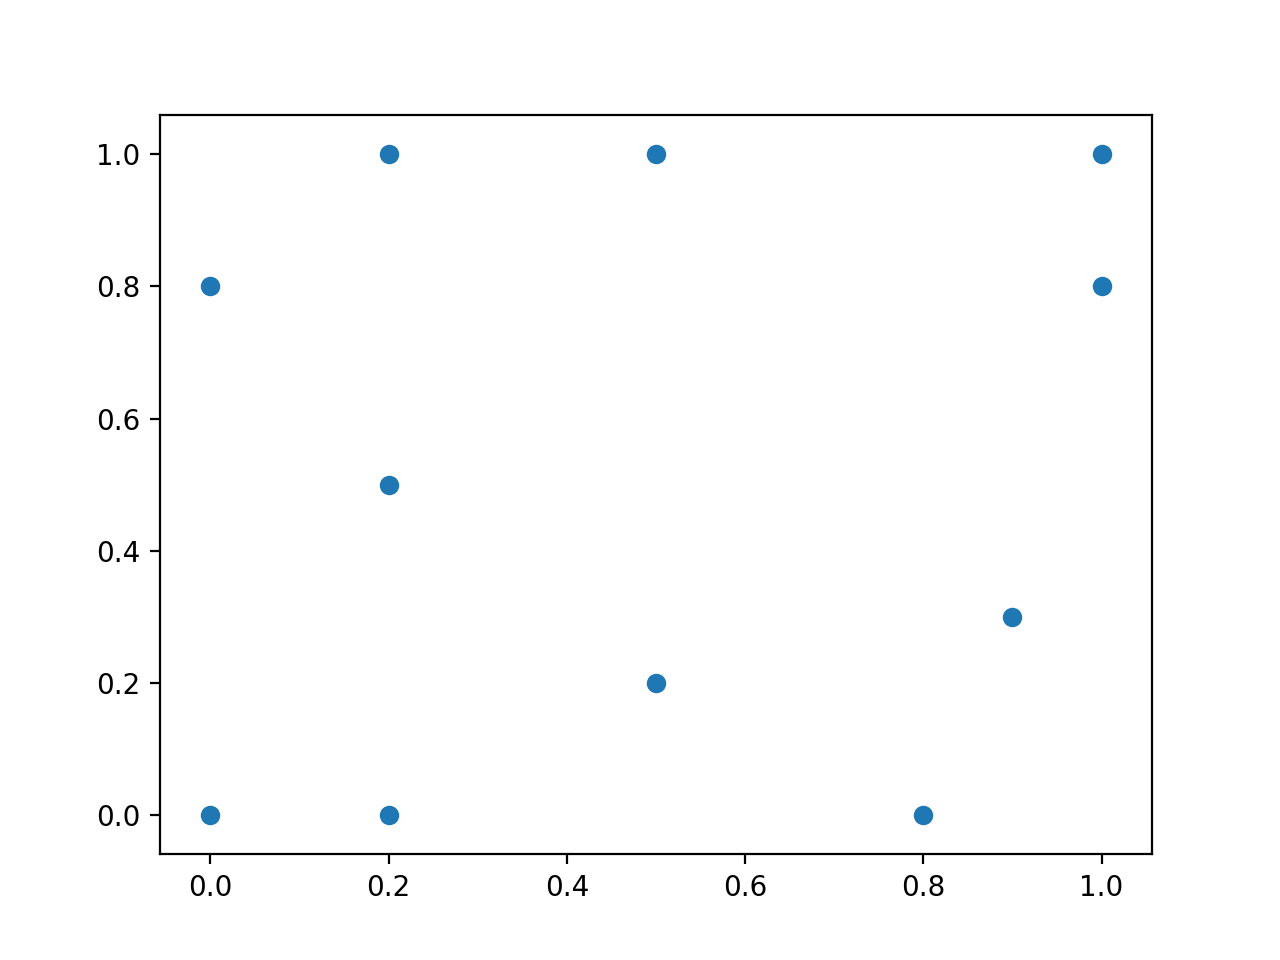

In [11]:
fig=plt.figure()
plt.scatter([i[0] for i in prod_.b_reg_set ],[i[1] for i in prod_.b_reg_set ])
plt.show()


In [37]:
n1 = list(prod_.nodes)[0]
print(n1)
v1 = prod_.val[n1]
v1.alpha_mat


(0, <node at x:-2 y:0>)


matrix([[0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.9703 , 0.9703 ],
        [0.     , 0.9606 , 0.     , 0.95099],
        [0.     , 0.9606 , 0.9703 , 0.9703 ]])

In [75]:
new_alph = []
mat = v1.alpha_mat
l = 4
new_mat = np.matrix([[]]*l)
for i in range(4):
    check_col =mat[:,0]
    mat = np.delete(mat,0,axis=1)
    Bool_m = check_col<= mat
    print(Bool_m)
    if not np.any(np.all(check_col<= mat, axis=0)) and not np.any(np.all( check_col<= new_mat, axis=0)):
        new_mat = np.column_stack((new_mat, check_col))
    print(new_mat)

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[]
[[ True  True]
 [ True  True]
 [False False]
 [ True  True]]
[[0.    ]
 [0.    ]
 [0.9606]
 [0.9606]]
[[ True]
 [ True]
 [ True]
 [ True]]
[[0.    ]
 [0.    ]
 [0.9606]
 [0.9606]]
[]
[[0.      0.     ]
 [0.      0.9703 ]
 [0.9606  0.95099]
 [0.9606  0.9703 ]]
